# Learning agents for Specification MDPs #

In this notebook we explore the implementations of 2 learning agents in the specification MDP domain. The first is the regular Q-learning to generate optimal policy in the optimal paradigm. The second one is soft-Q-Learning that generates maximum entropy policies that can represent multimodal optimal policies.

As usual we begin by importing our sample MDP problem

In [1]:
from utils import *
from Exploration import *
from LearningAgents import *
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16,9]

MDP = CreateSampleMDP()

Now lets define a standard Q-learning agent. This agent has $\gamma = 0.95$ and an $\epsilon$-greedy exploration policy with $\epsilon = 0.2$. We will train this agent for a maximum of 10000 episodes and an upper limit of number of actions taken to be 100,000. Each episode is limited to 20 actions.

In [ ]:
q_agent = QLearningAgent(MDP)
q_agent.Q_init = 0.01
q_agent.eps = 0.2
q_agent.explore(episode_limit = 10000, action_limit = 100000, verbose=True)
#q_agent.visualize_exploration(prog='twopi')


We can test how well this policy performed by initializing a second agent with the policy learned by the Q-learning agent.

[-1.0, -1.0, -0.94720000000000004, -0.77733333333333343, 1.0]

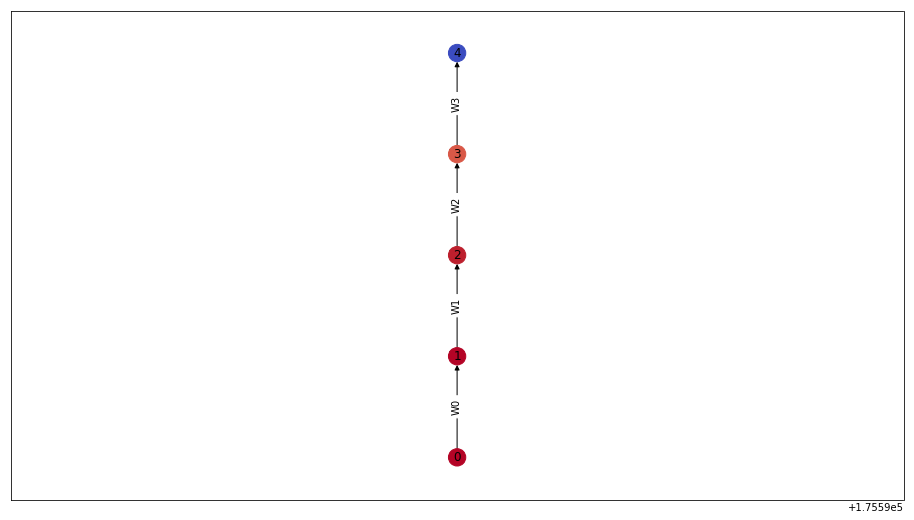

In [8]:
evaluator = ExplorerAgent(MDP, input_policy=q_agent.learned_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration(prog = 'twopi')

We can also visualize a distribution over the trajectories produced if a softmax policy with a very low temperature paramter was used to run at execution time. Here it is visualized over 1000 runs

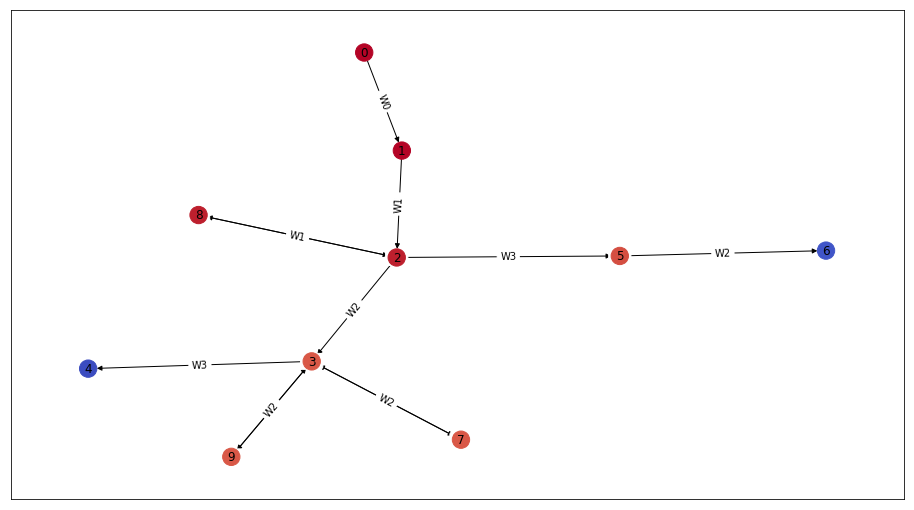

In [9]:
stochastic_evaluator = ExplorerAgent(MDP, input_policy = q_agent.create_learned_softmax_policy(temperature = 0.01))
stochastic_evaluator.explore(episode_limit = 1000)
_ = stochastic_evaluator.visualize_exploration(prog = 'neato')

We can also check what the final rewards for this are

In [10]:
rewards = [record[-1][3] for record in stochastic_evaluator.episodic_record]
print('Average terminal reward: ', np.mean(rewards))
print('Standard dev: ', np.std(rewards))

Average terminal reward:  0.997490533333
Standard dev:  0.0100219039744


Thus it looks like the softmax policy is accomplishing the assigned task to a very large extent when rolled out stochastically.

Now lets train a vanilla soft-q-learning agent

Training episode 5103         

[-1.0, -1.0]

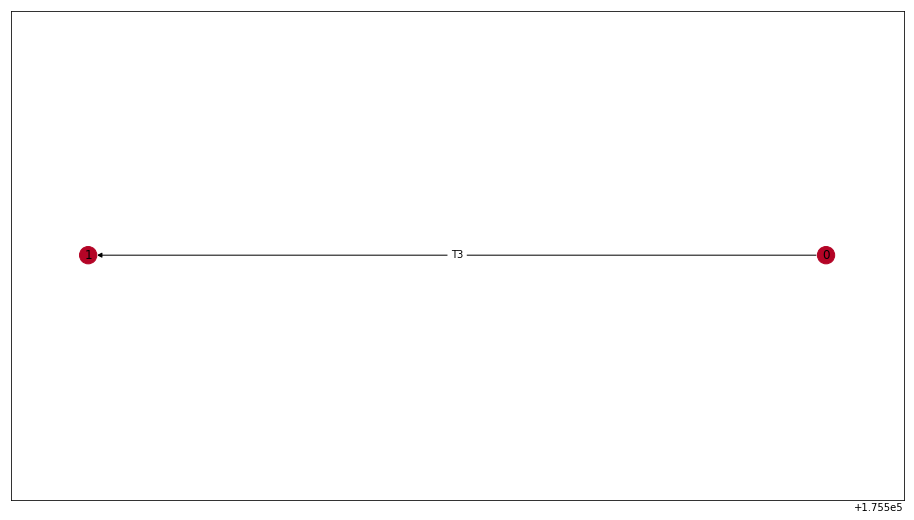

In [11]:
softmax_agent = QLearningAgent(MDP, soft_bellman=True)
softmax_agent.explore(episode_limit = 10000, action_limit = 100000, verbose = True)

evaluator = ExplorerAgent(MDP, input_policy=softmax_agent.learned_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration(prog = 'twopi')

This doesnt quite work. perhaps initializing the soft-Q-learning with the regular Q learning function might help?

In [3]:
softmax_agent = QLearningAgent(MDP, soft_bellman=True)
softmax_agent.Q_init = 0
softmax_agent.Q = q_agent.Q
softmax_agent.explore(episode_limit = 10000, action_limit = 100000, verbose = True)

NameError: name 'q_agent' is not defined

In [13]:
evaluator = ExplorerAgent(MDP, input_policy=softmax_agent.learned_softmax_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration(prog = 'twopi')

OSError: [Errno 12] Cannot allocate memory

In [ ]:
softmax_agent.MDP.initialize_state()
Qval = q_agent.get_max_Q_action(softmax_agent.MDP.state)[2]
softmax(Qval)

So it looks like the standard implementation of soft-Q-learning is not working very well in this domain. I am not sure if it is due to implementation issues or hyperparameter tuning issues. The agent does not seem to be exploring very well is is very confident in a not so good action very early on.

## Counterfactual updates to specification states ##

Because the actions only result in changes to the physical world (ControlMDP). We can use counterfactual reasoning to update the Q values for all specification states. The intuition behind this is, imagine if I took an action from a given controlMDP state that resulted in another controlMDP state, but I was in a different specification state. To do that simply enable the `counterfactual_update` flag while initializing the learning agent.

In [ ]:
cf_agent = QLearningAgent(MDP, counterfactual_updates=True, default_alpha=0.5)
cf_agent.explore(episode_limit = 200, action_limit = 200000, verbose = True)

Evaluating the deterministic policy learned by this automaton

In [ ]:
evaluator = ExplorerAgent(MDP, input_policy = cf_agent.learned_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration()

And in a stochastic setting

In [ ]:
# stochastic_evaluator = ExplorerAgent(MDP, input_policy = cf_agent.create_learned_softmax_policy(0.02))
# stochastic_evaluator.explore(episode_limit = 500)
_ = stochastic_evaluator.visualize_exploration(prog = 'neato')

# Testing on a second domain: No temporal orderings #

In this domain there are no temporal orderings, so any ordering that performs all the tasks is acceptable.

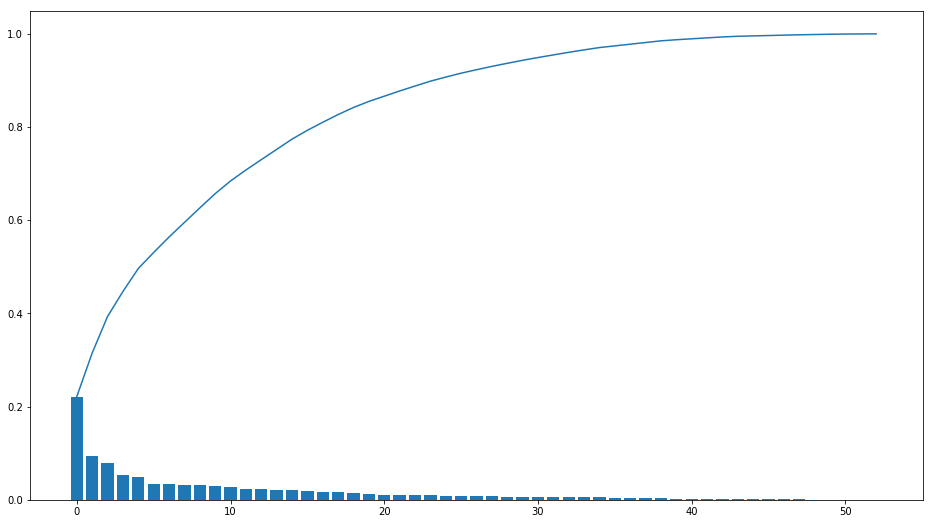

In [2]:
MDP2 = CreateSpecMDP('ExampleSpecs2.json', 5, 5)

First we try out the Q-learning agent with the same hyperparameters as before

In [4]:
q_agent2 = QLearningAgent(MDP2)
q_agent2.Q_init = 0.01
q_agent2.eps = 0.2
q_agent2.explore(episode_limit = 10000, action_limit = 100000, verbose=True)

Training episode 9647         

(100000, 9647)

Evaluation of the deterministic optimal policy

[-1.0000000000000002,
 -1.0000000000000002,
 -1.0000000000000002,
 -1.0000000000000002,
 -0.72760000000000014,
 0.99600000000000022]

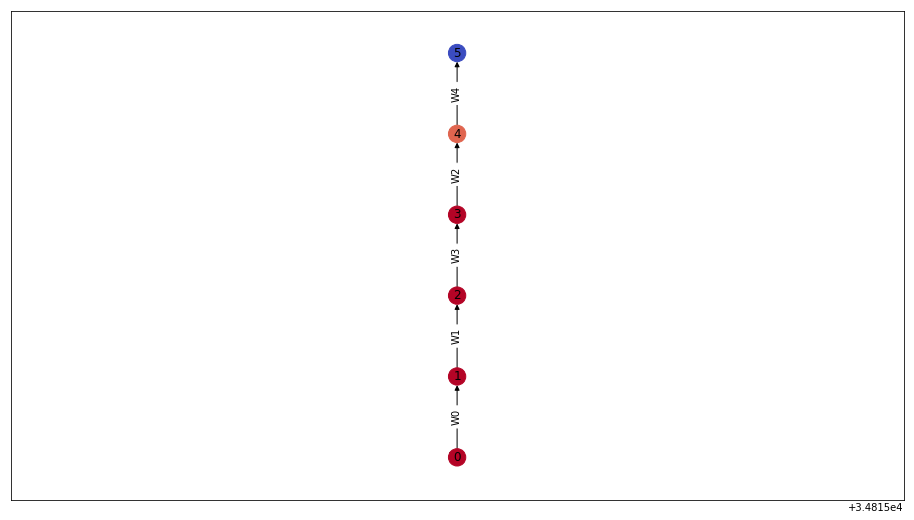

In [5]:
evaluator = ExplorerAgent(MDP2, input_policy=q_agent2.learned_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration(prog = 'twopi')

Evaluation on the stochastic policy

Average terminal reward:  0.996468
Std dev of terminal rewards:  0.00128568114243
Average episode length 7.424
Minimum episode length 5
Maximum episode length 18


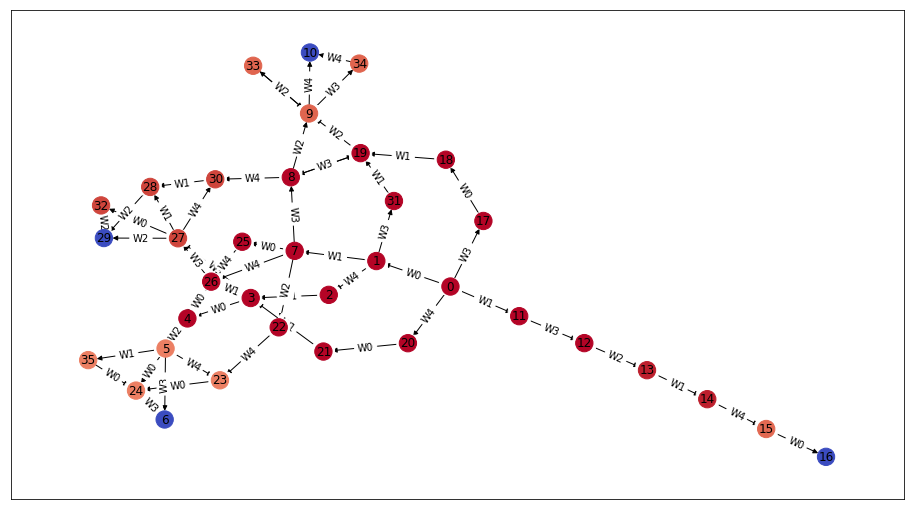

In [16]:
stochastic_evaluator = ExplorerAgent(MDP2, input_policy = q_agent2.create_learned_softmax_policy(temperature = 0.01))
stochastic_evaluator.explore(episode_limit = 1000)
_ = stochastic_evaluator.visualize_exploration(prog = 'neato')

rewards = [record[-1][3] for record in stochastic_evaluator.episodic_record]
print('Average terminal reward: ', np.mean(rewards))
print('Std dev of terminal rewards: ', np.std(rewards))
print('Average episode length', np.mean([len(record) for record in stochastic_evaluator.episodic_record]))
print('Minimum episode length', np.min([len(record) for record in stochastic_evaluator.episodic_record]))
print('Maximum episode length', np.max([len(record) for record in stochastic_evaluator.episodic_record]))

Now with the counterfactual updates

In [7]:
cf_agent2 = QLearningAgent(MDP2, counterfactual_updates=True, default_alpha=0.5)
cf_agent2.explore(episode_limit = 200, action_limit = 200000, verbose = True)

Training episode 199         

(2070, 200)

[-1.0000000000000002,
 -1.0000000000000002,
 -1.0000000000000002,
 -1.0000000000000002,
 -0.84599999999999997,
 0.99600000000000022]

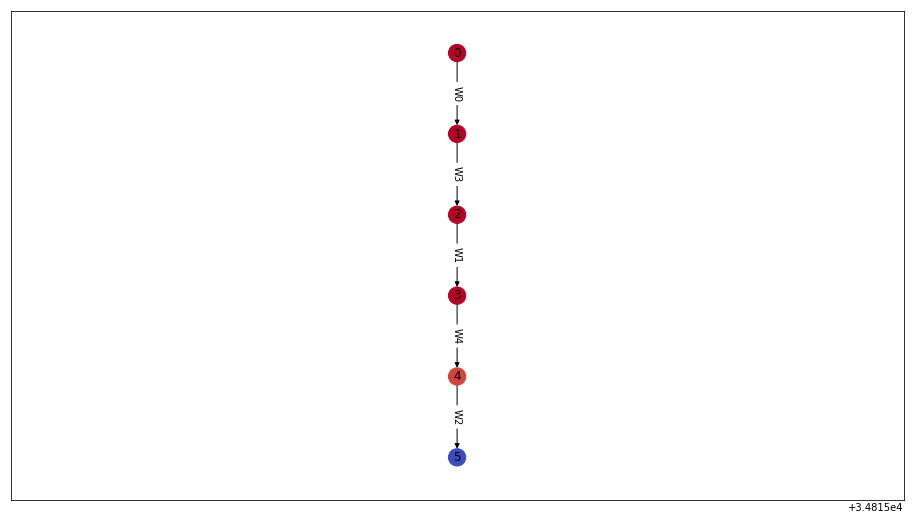

In [8]:
evaluator = ExplorerAgent(MDP2, input_policy = cf_agent2.learned_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration()

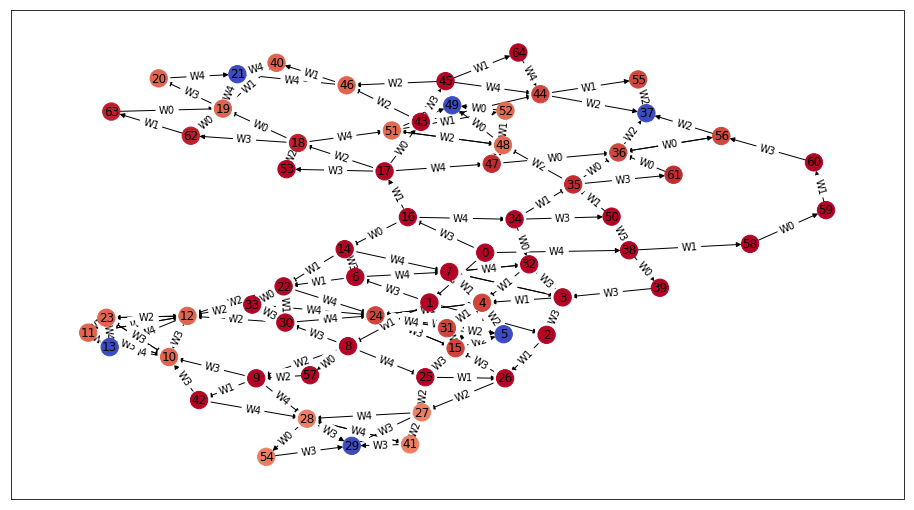

In [17]:
stochastic_evaluator = ExplorerAgent(MDP2, input_policy = cf_agent2.create_learned_softmax_policy(0.01))
stochastic_evaluator.explore(episode_limit = 500)
_ = stochastic_evaluator.visualize_exploration(prog = 'neato')

In [18]:
rewards = [record[-1][3] for record in stochastic_evaluator.episodic_record]
print('Average terminal reward: ', np.mean(rewards))
print('Std dev of terminal rewards: ', np.std(rewards))
print('Average episode length', np.mean([len(record) for record in stochastic_evaluator.episodic_record]))
print('Minimum episode length', np.min([len(record) for record in stochastic_evaluator.episodic_record]))
print('Maximum episode length', np.max([len(record) for record in stochastic_evaluator.episodic_record]))

Average terminal reward:  0.99644
Std dev of terminal rewards:  0.00125155902777
Average episode length 7.62
Minimum episode length 5
Maximum episode length 16


Checking the policy sizes for both the learning agents


In [23]:
print('policy size of the q-learning agent: ', len(q_agent2.Q))
print('policy size of the counterfactual learning agent: ', len(cf_agent2.Q))

print('exploration size of the q-learning agent: ', len(q_agent2.exploration_graph.nodes))
print('exploration size of the counterfactual learning agent: ', len(cf_agent2.exploration_graph.nodes))

print('largest possible policy size: ', len(MDP2.specification_fsm.states2id)*2**(len(MDP2.control_mdp.state)))

policy size of the q-learning agent:  13210
policy size of the counterfactual learning agent:  35830
exploration size of the q-learning agent:  1321
exploration size of the counterfactual learning agent:  3583
largest possible policy size:  345088


In [2]:
def RecordLearningCurve(MDP, Learner, max_episodes = 10000, steps = 10, temp = 0.02, verbose = False):
    episodes = 0
    mean_rewards = []
    rewards = []
    std_rewards = []
    mean_episode_length = []
    ep = []
    
    for i in range(0,max_episodes,steps):
        
        if verbose:
            print(f'\r Training and evaluating with {i} episodes        ', end = '')
        
        episodes = episodes + steps
        ep.append(episodes)
        Learner.explore(episode_limit = steps)
        evaluator = ExplorerAgent(MDP, input_policy = Learner.create_learned_softmax_policy(temp))
        evaluator.explore(episode_limit = 100)
        r = [record[-1][3] for record in evaluator.episodic_record]
        l = [len(record) for record in evaluator.episodic_record]
        
        rewards.append(r)
        mean_rewards.append(np.mean(r))
        std_rewards.append(np.std(r))
        mean_episode_length.append(np.mean(l))
        
    return mean_rewards, std_rewards, mean_episode_length, ep

In [4]:
q_agent = QLearningAgent(MDP)
LCRecords = RecordLearningCurve(MDP, q_agent, max_episodes = 5000, steps = 10, temp = 0.01, verbose = True)

 Training and evaluating with 4990 episodes        

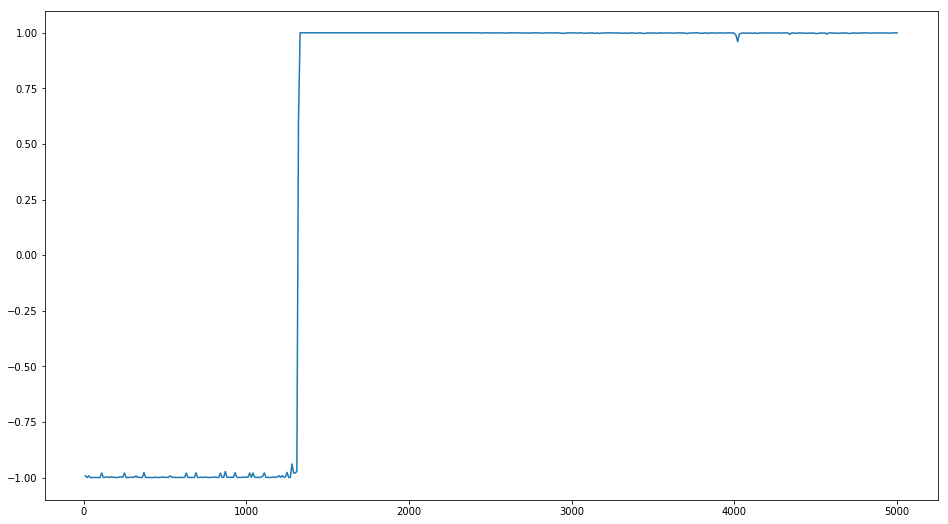

In [5]:
plt.plot(LCRecords[3], LCRecords[0])


 Training and evaluating with 145 episodes        

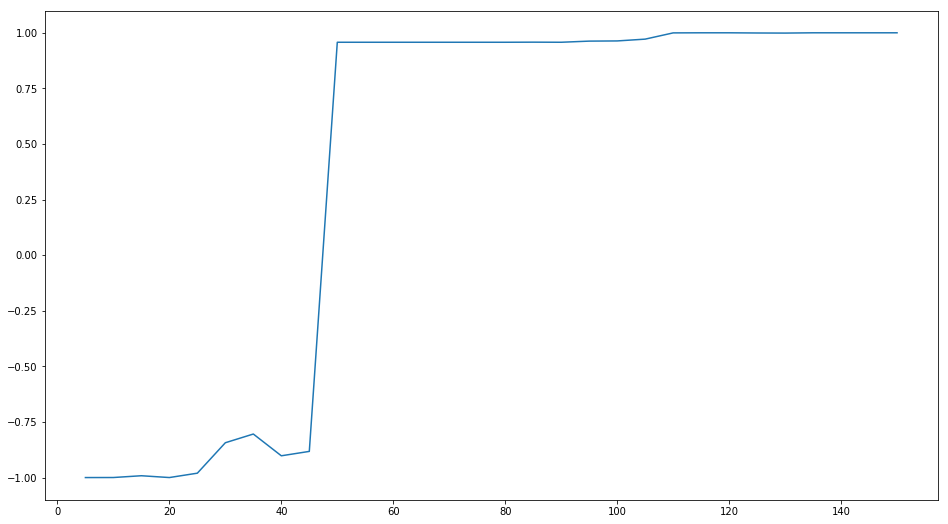

In [6]:
cf_agent = QLearningAgent(MDP, counterfactual_updates=True, default_alpha=0.5)
LCRecords = RecordLearningCurve(MDP, cf_agent, max_episodes = 150, steps = 5, temp = 0.01, verbose = True)
plt.plot(LCRecords[3], LCRecords[0])